In [15]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile

# Dumped Harmonic Oscillator FFNN baseline model

In this notebook, we will train a PINN with a loss given by:

- loss_ode=   $\frac{1}{N} \sum_i  ( \frac{d{n(t_i)}}{dt} - D[n(t_i)])^2$.

- loss_ic=    $ (n(t_0) -x_0)^2$

Where $n$ is the model itself and $D[n(t)]$ is the operator for the specific ODE.

The architecture, number of data point, epochs and hyperparamenters, all shared with the ../models/FFNN_baseline_model.pt, will be the baseline for further improvements.
Another difference is that this loss function do not need the solution of the ODE, so we will use $t_i ~ U(0,30)$, so with $t_i \in TestTime$, this is not cheating, since no info about the solution is provided to the model. To try to be fair, we will use the same number of data points as the FFNN baseline model.

In [16]:
# Number of epochs
n_epochs = 50000

# Batch size
batch_size = 595

# Learning rate and scheduler
lr = 0.01
factor = 0.9
patience = 200

# Model architecture
n_layers = 3
n_neurons = 20

In [17]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 2))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

## Load data

In [18]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/DHOscillator_data.npy')
X = data[:,0]
Y = data[:,1:]

In [19]:
def data_loader(X, Y, batch_size):
    """
    Function to load data and divide it in batches
    input: X, Y, batch_size
    output: train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    """

    # divide in train, validation and test
    train_frac = 0.7
    val_frac = 0.15
    test_frac = 0.15

    train_val_X = X[:int((train_frac+val_frac)*len(X))]
    train_val_Y = Y[:int((train_frac+val_frac)*len(X)), :]
    train_X, val_X, train_Y, val_Y = train_test_split(
        train_val_X, 
        train_val_Y, 
        test_size=val_frac/(train_frac+val_frac), 
        random_state=42
        )

    test_X = X[int((train_frac+val_frac)*len(X)):]
    test_Y = Y[int((train_frac+val_frac)*len(X)):, :]

    # convert to torch tensor
    train_X = torch.tensor(train_X, dtype=torch.float32).view(-1, 1)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    val_X = torch.tensor(val_X, dtype=torch.float32).view(-1, 1)
    val_Y = torch.tensor(val_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32).view(-1, 1)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    # divide in batches train
    train_X_batches = torch.split(train_X, batch_size)
    train_Y_batches = torch.split(train_Y, batch_size)

    
    return train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y

In [20]:
# use the data loader to get the data, in this example we use only one batch
train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(X, Y, batch_size)

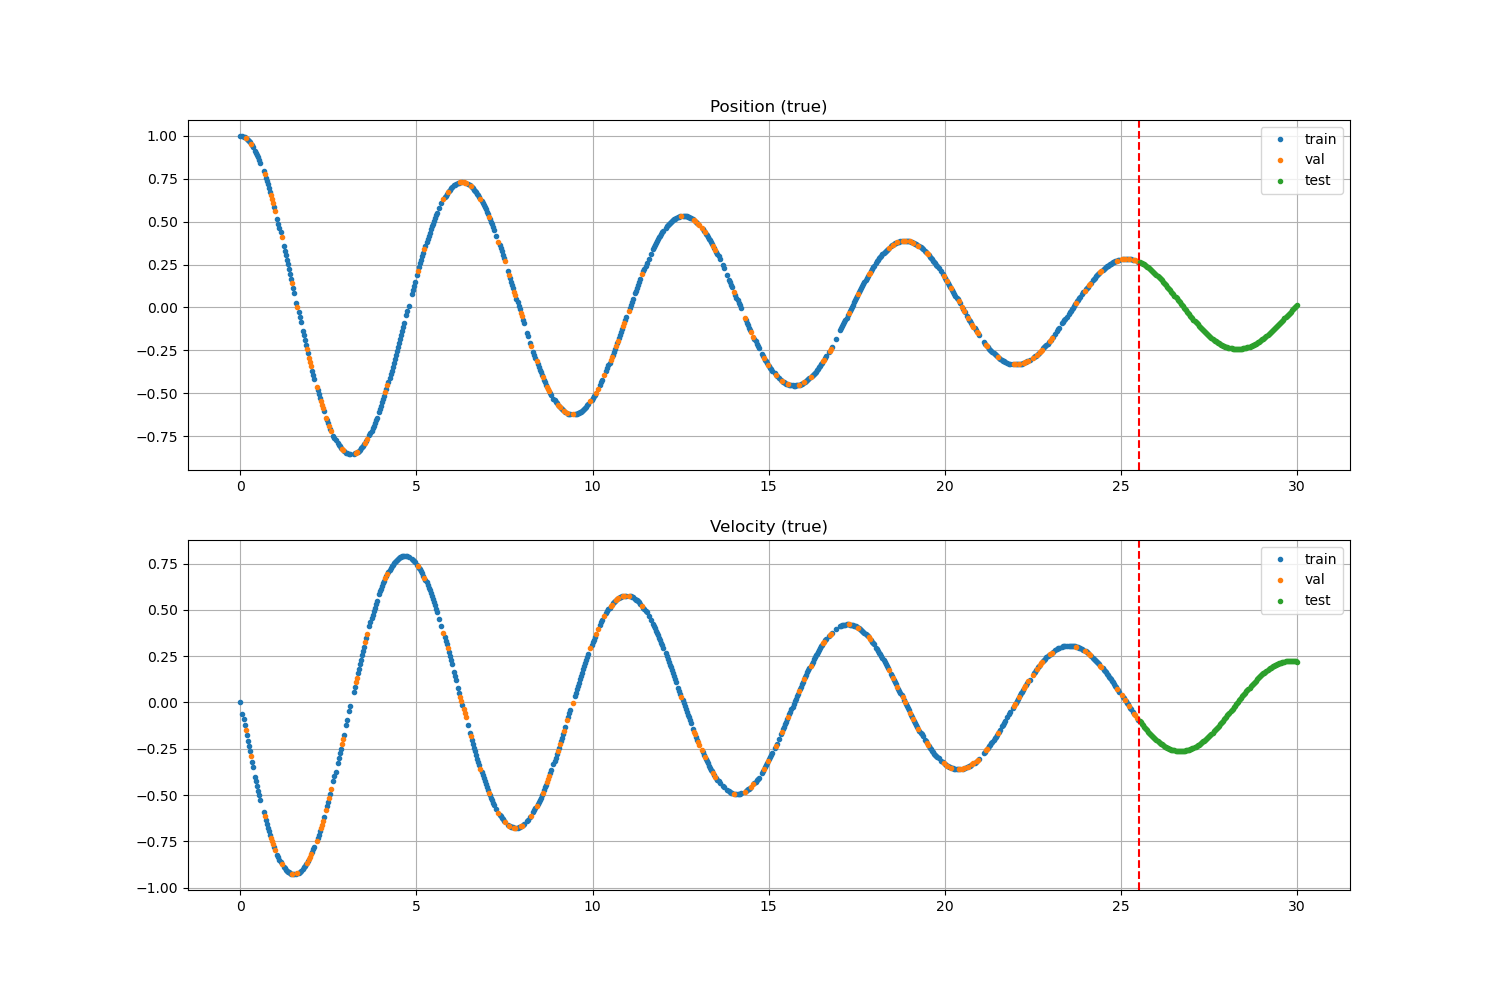

In [21]:
# plot the position 
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy(), '.', label='train')
plt.plot(val_X.detach().numpy(), val_Y[:, 0].detach().numpy(), '.', label='val')
plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy(), '.', label='test')
plt.grid()
plt.title('Position (true)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()

# plot the velocity
plt.subplot(2, 1, 2)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy(), '.', label='train')
plt.plot(val_X.detach().numpy(), val_Y[:, 1].detach().numpy(), '.', label='val')
plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy(), '.', label='test')
plt.grid()
plt.title('Velocity (true)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()

# save the figure
plt.savefig('../plot/DHOscillator_data.png')


## PINN

The PINN will be trained again with 595 point, but since this time we do not need the solution of the ODE to train the model, we can use point also with t>25 until t = 30.
We chose a uniform distribution of the points in the time span (0,30). To enlight the fact that this train method do not need the solution of the ODE, we will use dummy_train_Y = zeros as the target of the training (it is not used anyway).

In [22]:
# data for PINN, NO SOLUTION NEEDED
dummy_train_X = np.linspace(0, 30, 595)
dummy_train_Y = np.zeros((595, 2))

dummy_train_X_batches = torch.split(torch.tensor(dummy_train_X, dtype=torch.float32).view(-1, 1), 595)
dummy_train_Y_batches = torch.split(torch.tensor(dummy_train_Y, dtype=torch.float32), 595)

In [23]:
# define the model
model_PINN = FFNN(n_layers, n_neurons)

# define the loss function, mean squared error
loss_fn = torch.nn.MSELoss()

# define the optimizer
optimizer = torch.optim.Adam(model_PINN.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience)

In [24]:
%%time
history_PINN = []

# train the model
for epoch in range(n_epochs):
    for i, (X, Y) in enumerate(zip(dummy_train_X_batches, dummy_train_Y_batches)):

        optimizer.zero_grad()
        X.requires_grad = True
        Y_pred = model_PINN(X)

        # get the derivatives
        dx_dt = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
        dv_dt = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]

        # loss_ode and loss_ic 
        loss_ode = torch.mean((dx_dt[:,0] - Y_pred[:,1])**2 + (dv_dt[:,0] + 0.1*Y_pred[:,1] + Y_pred[:,0])**2)
        loss_ic = ((Y_pred[0,0] - 1)**2 + (Y_pred[0,1] - 0)**2)

        loss = loss_ode + loss_ic
        
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        history_PINN.append([loss.item(), optimizer.param_groups[0]['lr']])

    if epoch % 10000 == 0:
        print(epoch, loss.item())

0 0.9949115514755249
10000 0.0006708101136609912
20000 0.0002449500316288322
30000 0.00013044464867562056
40000 7.554715557489544e-05
CPU times: user 9min, sys: 3.96 s, total: 9min 4s
Wall time: 2min 16s


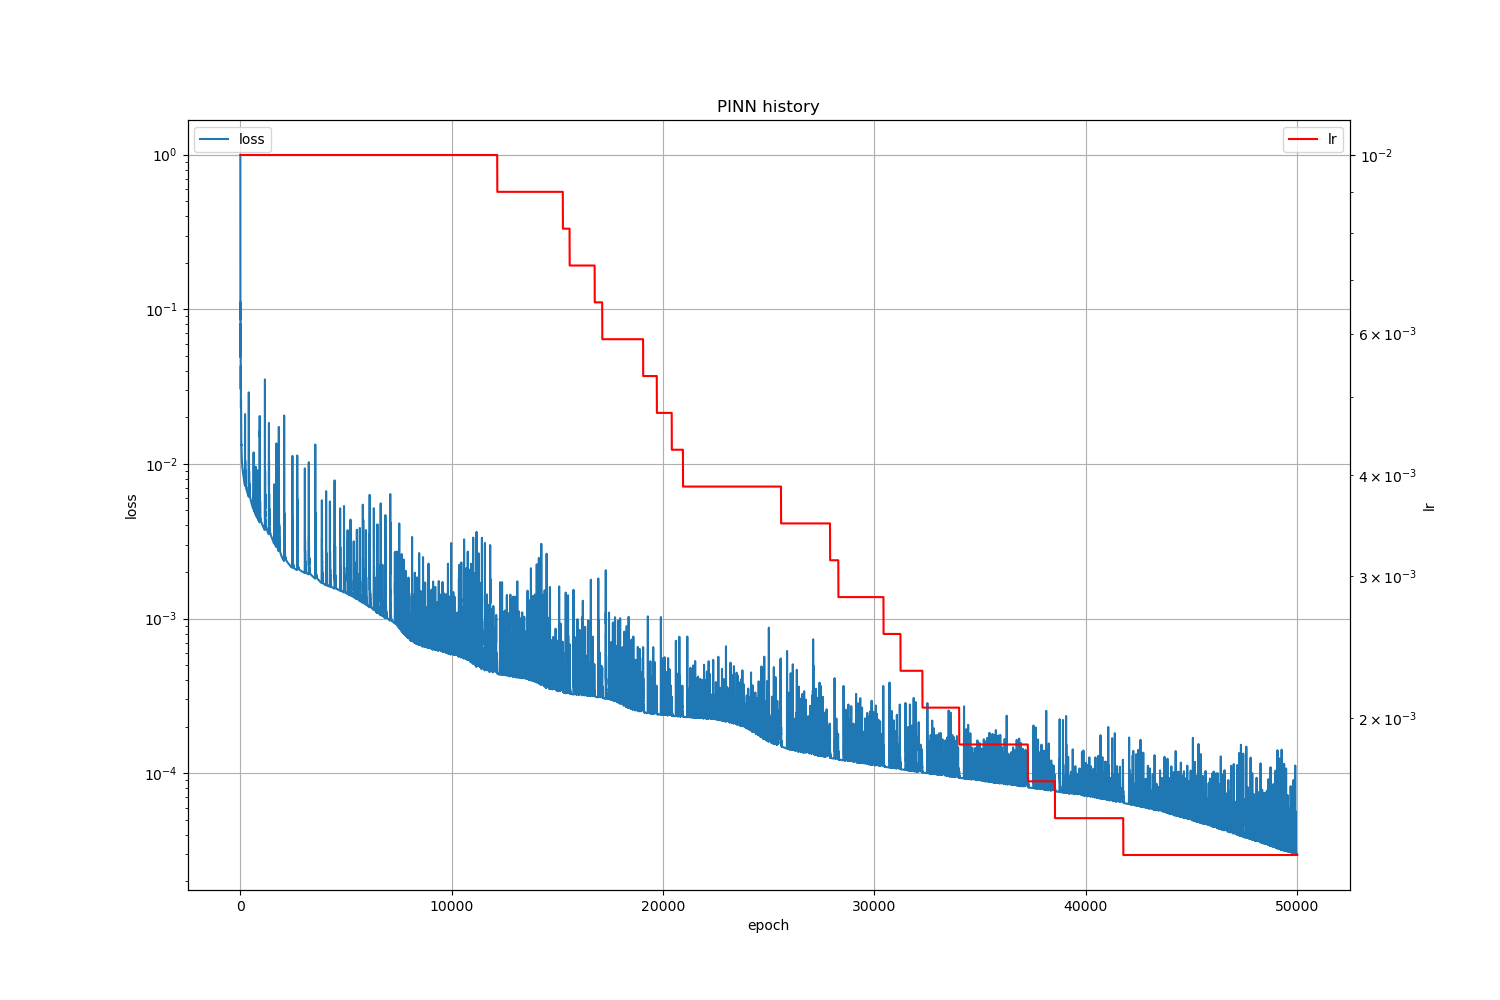

In [25]:
# plot history_PINN loss and lr in two subplots
history_PINN = np.array(history_PINN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN[:, 1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')

# save the figure
plt.savefig('../plot/DHOscillator_PINN_baseline_history.png')

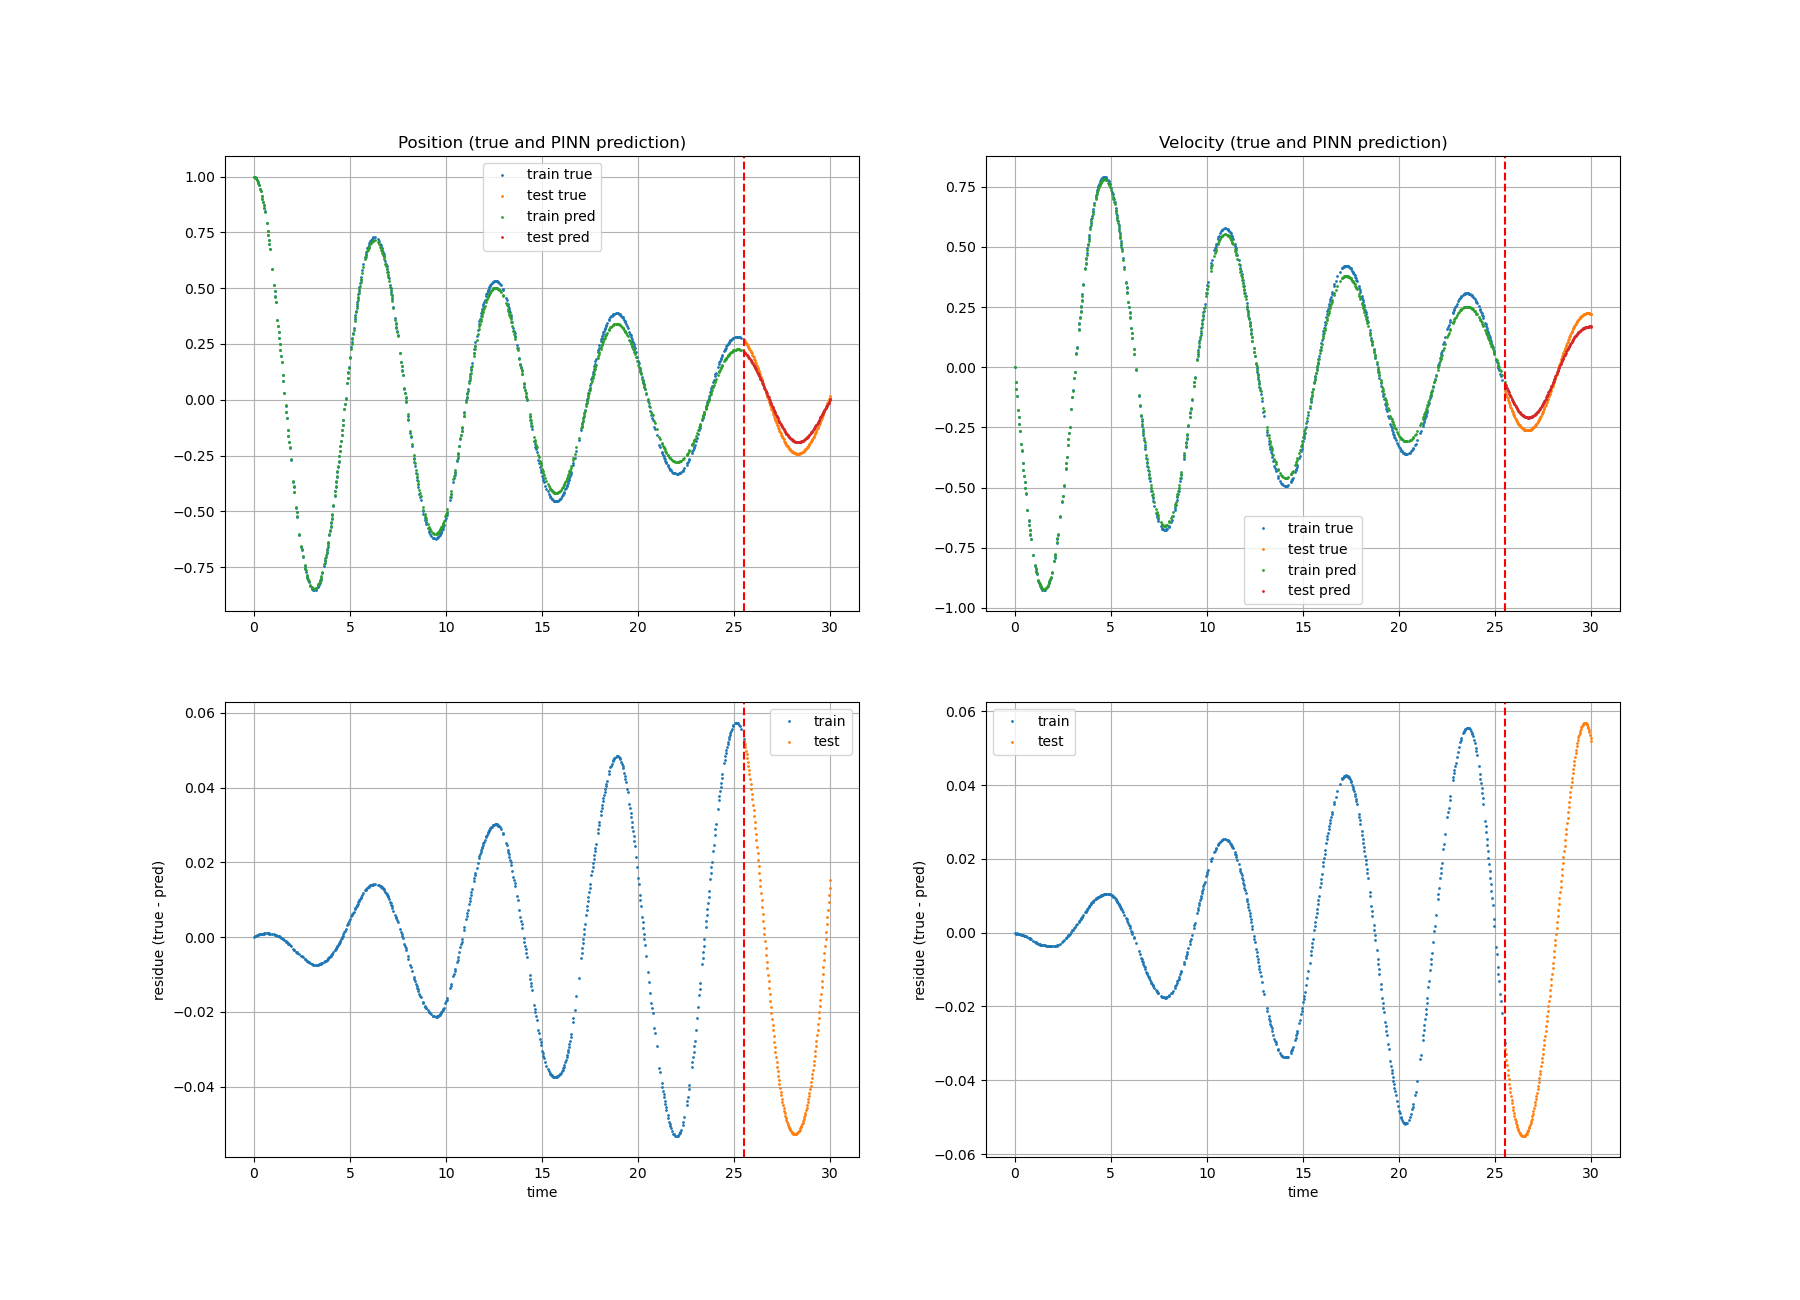

In [26]:
# get predictions
Y_pred_train = model_PINN(train_X_batches[0])
Y_pred_val = model_PINN(val_X)
Y_pred_test = model_PINN(test_X)

# plot the position, and subplot the residue
plt.figure(figsize=(18, 13))
plt.subplot(2, 2, 1)

marker='.'
markersize=2

plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy(), marker, label='train true', markersize=markersize)
plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy(), marker, label='test true', markersize=markersize)
plt.plot(train_X_batches[0].detach().numpy(), Y_pred_train[:, 0].detach().numpy(), marker, label='train pred', markersize=markersize)
plt.plot(test_X.detach().numpy(), Y_pred_test[:, 0].detach().numpy(), marker, label='test pred', markersize=markersize)
plt.grid()

plt.title('Position (true and PINN prediction)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 0].detach().numpy()-Y_pred_train[:, 0].detach().numpy(), marker, label='train', markersize=markersize)
plt.plot(test_X.detach().numpy(), test_Y[:, 0].detach().numpy()-Y_pred_test[:, 0].detach().numpy(), marker, label='test', markersize=markersize)
plt.grid()
plt.ylabel('residue (true - pred)')
plt.xlabel('time')
plt.legend()
plt.axvline(x=30*0.85, color='r', linestyle='--')


# new figure for the velocity
plt.subplot(2, 2, 2)

plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy(), marker, label='train true', markersize=markersize)
plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy(), marker, label='test true', markersize=markersize)
plt.plot(train_X_batches[0].detach().numpy(), Y_pred_train[:, 1].detach().numpy(), marker, label='train pred', markersize=markersize)
plt.plot(test_X.detach().numpy(), Y_pred_test[:, 1].detach().numpy(), marker, label='test pred', markersize=markersize)
plt.grid()

plt.title('Velocity (true and PINN prediction)')
plt.axvline(x=30*0.85, color='r', linestyle='--')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_X_batches[0].detach().numpy(), train_Y_batches[0][:, 1].detach().numpy()-Y_pred_train[:, 1].detach().numpy(), marker, label='train', markersize=markersize)
plt.plot(test_X.detach().numpy(), test_Y[:, 1].detach().numpy()-Y_pred_test[:, 1].detach().numpy(), marker, label='test', markersize=markersize)
plt.grid()
plt.ylabel('residue (true - pred)')
plt.xlabel('time')
plt.legend()
plt.axvline(x=30*0.85, color='r', linestyle='--')

# save the figure
plt.savefig('../plot/DHOscillator_PINN_baseline_results.png')

In [27]:
# test loss
loss_test_PINN = loss_fn(Y_pred_test, test_Y)
print('test loss:', loss_test_PINN.item())

test loss: 0.0015676728216931224


Comment:
the model reproduce qualitative the behaviuor of the solution for all the time span.

In [28]:
# save model
torch.save(model_PINN, '../models/DHO_PINN_baseline.pt')